#### This notebook contains all the exploration steps run on raw data before it is ready to ingest into a database

In [1]:
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
import oso

In [ ]:
conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.driver.memory','3g')
conf.set('spark.ui.showConsoleProgress', False)
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

### Twitter Dataset

In [3]:
twitter_data = spark.read.csv('../data/Twitter_Data.csv', multiLine=True, header=True).select(['clean_text', 'category'])

In [4]:
twitter_data.count()

107760

In [4]:
twitter_data.printSchema()
twitter_data.show(10)

root
 |-- clean_text: string (nullable = true)
 |-- category: string (nullable = true)

+--------------------+--------+
|          clean_text|category|
+--------------------+--------+
|when modi promise...|    -1.0|
|what did just say...|     1.0|
|asking his suppor...|     1.0|
|answer who among ...|     1.0|
|with upcoming ele...|     1.0|
|gandhi was gay do...|     1.0|
|things like demon...|     1.0|
|hope tuthukudi pe...|     1.0|
|calm waters where...|     1.0|
|vote such party a...|    -1.0|
+--------------------+--------+
only showing top 10 rows



In [5]:
twitter_data = twitter_data.withColumnRenamed('clean_text', 'text')

Checking for NULL rows

In [6]:
twitter_data.filter((F.col('category').isNull() | F.col('text').isNull())).count()

2

Removing NULL rows

In [7]:
twitter_data = twitter_data.filter(~(F.col('category').isNull() | F.col('text').isNull()))

This DataFrame has 2 categories:

-1 $\Rightarrow$ Negative sentiment <br>
1 $\Rightarrow$ Positive sentiment

In [8]:
twitter_data.select('category').distinct().show()

+--------+
|category|
+--------+
|     1.0|
|    -1.0|
+--------+



### Sentiment140 Dataset

In [9]:
sentiment140Schema = T.StructType([
    T.StructField("target", T.StringType(), True),        
    T.StructField("id", T.StringType(), True),
    T.StructField("date", T.StringType(), True),
    T.StructField("flag", T.StringType(), True),
    T.StructField("user", T.StringType(), True),
    T.StructField("text", T.StringType(), True),
])
sentiment140_spark = spark.read.csv('../data/sentiment140.csv', schema=sentiment140Schema)

In [10]:
sentiment140_spark.printSchema()
sentiment140_spark.columns

root
 |-- target: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



['target', 'id', 'date', 'flag', 'user', 'text']

In [11]:
sentiment140_spark.show(10)

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

The columns ```id``` and ```user``` do not hold any such information that the mode can learn. So these columns can be dropped.

We will check what other values the ```flag``` column holds

In [12]:
sentiment140_spark.select('flag').distinct().show()

+--------+
|    flag|
+--------+
|NO_QUERY|
+--------+



Since there is only one unique entry in this column, our model cannot learn anything from this column. So we can drop this column

In [13]:
sentiment140_spark = sentiment140_spark.drop(*['id', 'user', 'flag'])

In [14]:
sentiment140_spark.columns

['target', 'date', 'text']

We will modify the ```date``` field to hold date time values that can be parsed easily

In [15]:
sentiment140_spark.select('date').first()[0]

'Mon Apr 06 22:19:45 PDT 2009'

Creating UDF to transform the ```date``` column

In [16]:
from datetime import datetime

In [17]:
import calendar
month_mapper = {month: index for index, month in enumerate(calendar.month_abbr) if month}

In [18]:
def transform_date(date):
  date_split = date.replace('PDT', '').split()[1:]
  month = month_mapper[date_split[0]]
  day = date_split[1]
  time = date_split[2]
  year = date_split[3]
  date_string = str(month) + ' ' + str(day) + ' ' + str(time) + ' ' + str(year)
  datetime_object = datetime.strptime(date_string, '%m %d %H:%M:%S %Y')
  return str(datetime_object)  # printed in default format
transform_date_udf = F.udf(transform_date)

In [19]:
sentiment140_spark = sentiment140_spark\
  .withColumn('Date', transform_date_udf(F.col('date'))).select(['target', 'Date', 'text'])

In [20]:
sentiment140_spark.show(10)

+------+-------------------+--------------------+
|target|               Date|                text|
+------+-------------------+--------------------+
|     0|2009-04-06 22:19:45|@switchfoot http:...|
|     0|2009-04-06 22:19:49|is upset that he ...|
|     0|2009-04-06 22:19:53|@Kenichan I dived...|
|     0|2009-04-06 22:19:57|my whole body fee...|
|     0|2009-04-06 22:19:57|@nationwideclass ...|
|     0|2009-04-06 22:20:00|@Kwesidei not the...|
|     0|2009-04-06 22:20:03|         Need a hug |
|     0|2009-04-06 22:20:03|@LOLTrish hey  lo...|
|     0|2009-04-06 22:20:05|@Tatiana_K nope t...|
|     0|2009-04-06 22:20:09|@twittera que me ...|
+------+-------------------+--------------------+
only showing top 10 rows



Now the dataframe has properly formatted date.

We will now view how many unique values of ```target``` are there in our data

In [21]:
sentiment140_pandas = sentiment140_spark.toPandas()

In [22]:
sentiment140_pandas.columns

Index(['target', 'Date', 'text'], dtype='object')

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [37]:
sentiment140_pandas['Date'] = pd.to_datetime(sentiment140_pandas['Date'])

# Group by date and sentiment
grouped = sentiment140_pandas.groupby([sentiment140_pandas['Date'].dt.date, 'target']).size().unstack(fill_value=0)
grouped.columns = ['Negative', 'Positive']


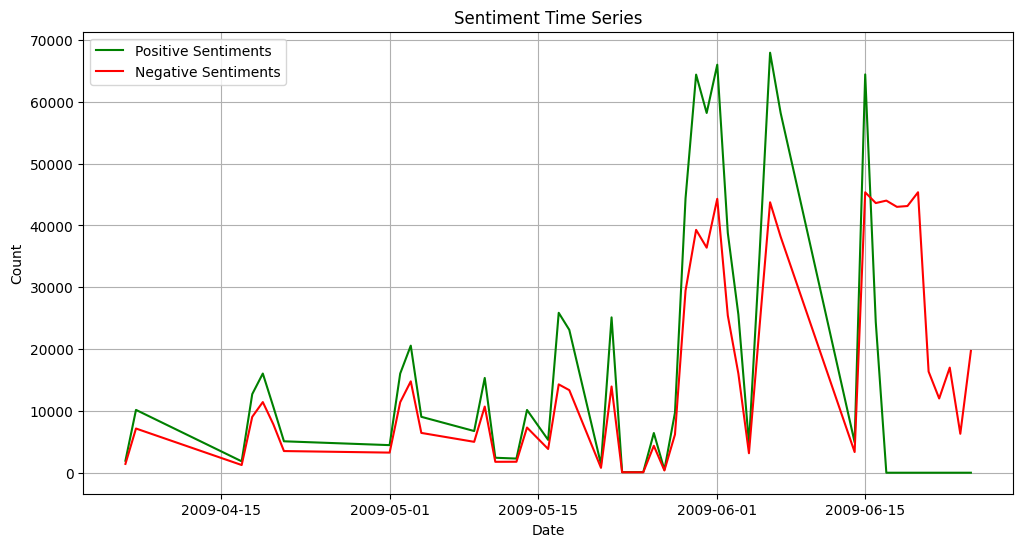

In [38]:
# Plotting
plt.figure(figsize=(12, 6))
grouped['Positive'].plot(color='green', label='Positive Sentiments')
grouped['Negative'].plot(color='red', label='Negative Sentiments')
plt.title('Sentiment Time Series')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

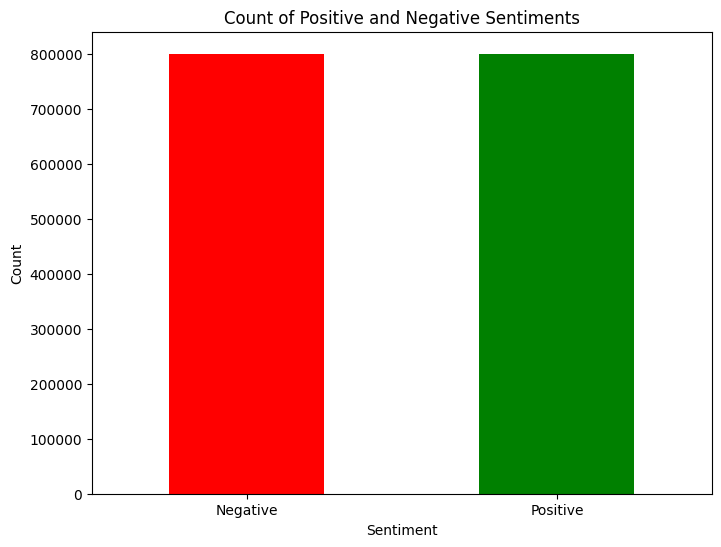

In [48]:
sentiment_counts = sentiment140_pandas['target'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Count of Positive and Negative Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

In [28]:
sentiment140_spark.groupBy('target').agg(F.count('target').alias('Count')).show()

+------+------+
|target| Count|
+------+------+
|     0|800000|
|     4|800000|
+------+------+



This DataFrame has equal number of occurences of the 2 categories:

0 $\Rightarrow$ Negative sentiment <br>
4 $\Rightarrow$ Positive sentiment

We will have common labels across dataframes $\rightarrow 0$ will signify negative sentiment and $1$ will signify positive sentiment

We will write a UDF to perform this transformation

In [23]:
def common_label_transform(label_value, negative_sentiment, positive_sentiment):
  return 0 if label_value == negative_sentiment else 1
common_label_transform_udf = F.udf(common_label_transform)

In [24]:
# twitter_data = twitter_data\
#   .withColumn('label', F.lit(common_label_transform_udf(F.col('category'), F.lit("-1.0"), F.lit("1.0"))))\
#   .select(['text', 'label'])

In [25]:
sentiment140_spark = sentiment140_spark\
  .withColumn('label', F.lit(common_label_transform_udf(F.col('target'), F.lit("0"), F.lit("4"))))\
  .select(['text', 'label'])

In [28]:
sentiment140_spark.count()

1600000

Export all the preprocessed spark dataframes into database - here, we are using MongoDb

Storing in csv files for now $\rightarrow$ (create the folder ```data-processed``` if it is not present)

In [26]:
positive_sentiments = sentiment140_spark.filter(F.col('label') == 1).limit(500)
negative_sentiments = sentiment140_spark.filter(F.col('label') == 0).limit(500)

In [27]:
reduced_df = positive_sentiments.union(negative_sentiments)

In [35]:
reduced_df.toPandas().to_csv('../data/reduced_data.csv')

In [26]:
# twitter_data.toPandas().to_csv('../data-processed/Twitter_Data.csv')
# sentiment140 = sentiment140_spark.toPandas().to_csv('../data-processed/sentiment140_data.csv')